In [1]:
import torch
import requests
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import csv
import json
import torchvision.transforms as T

from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from transformers import AutoImageProcessor, SuperPointForKeypointDetection
from tqdm import tqdm
from PIL import Image



In [ ]:
# Load SuperPoint model and processor
processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.21M [00:00<?, ?B/s]

## Image to global descriptors

In [ ]:
# CLAHE and Intensity Normalization for Preprocessing
def apply_clahe(image, clip_limit=4.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE to enhance image contrast.
    """
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

def normalize_intensity(image):
    """
    Normalize pixel intensity to range [0, 255].
    """
    image = np.array(image).astype(np.float32)
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

def preprocess_image(image_path, target_size=(1024, 1024)):
    """
    Preprocess image: CLAHE -> Normalization -> Resize -> RGB conversion.
    """
    image = Image.open(image_path).convert("RGB")
    clahe_image = apply_clahe(image)
    normalized_image = normalize_intensity(clahe_image)

    # Convert back to RGB (3 channels)
    rgb_image = cv2.cvtColor(normalized_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    resized_image = Image.fromarray(rgb_image).resize(target_size)
    return resized_image

def preprocess_image_batch(image_paths, target_size=(1024, 1024)):
    """
    Preprocess a batch of images using the same pipeline.
    """
    return [preprocess_image(image_path) for image_path in image_paths]

def extract_features_batch(images, processor, model):
    """
    Extract features for a batch of images using the SuperPoint model.
    """
    inputs = processor(images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    keypoints = [o.cpu().numpy() for o in outputs.keypoints]
    descriptors = [o.cpu().numpy() for o in outputs.descriptors]
    return keypoints, descriptors

def generate_ground_truths(ground_truth_folder, batch_size=8):
    """
    Generate global descriptors for each view as a list of arrays,
    where each array contains the descriptors for an individual image with shape (256, N_i).
    """
    ground_truth_features = {}
    for view in os.listdir(ground_truth_folder):
        view_path = os.path.join(ground_truth_folder, view, "masked")
        if os.path.isdir(view_path):
            print(f"Processing view: {view}")

            # Collect image paths for the view
            image_paths = [os.path.join(view_path, img) for img in os.listdir(view_path) if img.endswith(('.jpg', '.png', '.jpeg'))]

            if image_paths:
                descriptors_list = []
                for i in range(0, len(image_paths), batch_size):
                    batch_paths = image_paths[i:i + batch_size]
                    batch_images = preprocess_image_batch(batch_paths, target_size=(1024, 1024))
                    _, batch_descriptors = extract_features_batch(batch_images, processor, model)

                    for d in batch_descriptors:
                        if d.size > 0:
                            descriptors_list.append(d.T)  # Transpose to (256, N_i)

                    torch.cuda.empty_cache()  # Clear GPU memory after each batch

                ground_truth_features[view] = descriptors_list
                print(f"View '{view}' processed. Total images: {len(descriptors_list)}")
    return ground_truth_features

def compare_image_to_views(image_descriptors, ground_truth_features):
    """
    Compute a single similarity score for an image against each view using cosine similarity.
    """
    # Normalize image descriptors
    image_descriptors = torch.tensor(image_descriptors).to(device)
    image_descriptors /= torch.norm(image_descriptors, dim=1, keepdim=True) + 1e-8

    scores = {}
    for view, combined_descriptors in ground_truth_features.items():
        try:
            # Ensure combined_descriptors is a torch tensor and move to GPU
            ground_truth = torch.tensor(combined_descriptors).to(device)

            # Perform cosine similarity computation
            similarity_matrix = torch.matmul(image_descriptors, ground_truth)

            # # Use softmax to weight similarities for all descriptors
            # threshold = 0.4
            # similarity_matrix[similarity_matrix < threshold] = -float(1e-8)
            # softmax_weights = torch.softmax(similarity_matrix / .3 , dim=1)
            # weighted_similarities = torch.sum(softmax_weights * similarity_matrix, dim=1)
            # final_similarity = torch.mean(weighted_similarities).item()

            # # Compute row-wise max similarities and their mean
            # max_similarities = torch.max(similarity_matrix, dim=1).values
            # final_similarity = torch.mean(max_similarities).item()

            # Sort similarities row-wise and take the top K
            top_k=3
            top_k_similarities, _ = torch.topk(similarity_matrix, k=top_k, dim=1)
            # Compute the row-wise average of the top K similarities
            avg_top_k_similarities = torch.mean(top_k_similarities, dim=1)
            # Compute the final similarity as the mean of these averages
            final_similarity = torch.mean(avg_top_k_similarities).item()


            scores[view] = final_similarity

        except Exception as e:
            print(f"Error while processing view {view}: {e}")
            raise RuntimeError(f"Error while processing view {view}: {e}")
    return scores


def compute_dicom_scores(masked_folder, ground_truth_features, batch_size=64):
    """
    Compute similarity scores for each DICOM by averaging image-level scores using cosine similarity.
    """
    from collections import defaultdict

    dicom_image_mapping = defaultdict(list)
    for image_file in os.listdir(masked_folder):
        if image_file.endswith(('.jpg', '.png', '.jpeg')):
            dicom_id = image_file.split('.')[0]  # Adjust splitting logic to extract DICOM ID
            dicom_image_mapping[dicom_id].append(os.path.join(masked_folder, image_file))

    dicom_scores = {}

    # Initialize tqdm progress bar
    with tqdm(total=len(dicom_image_mapping), desc="Processing DICOMs") as pbar:
        for dicom_id, image_paths in dicom_image_mapping.items():
            image_scores = {view: [] for view in ground_truth_features.keys()}
            batch_images = []

            for image_path in image_paths:
                # Use preprocess_image to match ground truth preprocessing
                preprocessed_image = preprocess_image(image_path)
                batch_images.append(preprocessed_image)

                if len(batch_images) == batch_size:  # Process in batches
                    _, batch_descriptors = extract_features_batch(batch_images, processor, model)
                    for descriptors in batch_descriptors:
                        scores = compare_image_to_views(descriptors, ground_truth_features)
                        for view, score in scores.items():
                            image_scores[view].append(score)
                    batch_images = []
                    torch.cuda.empty_cache()  # Clear GPU memory after processing a batch

            # Process remaining images
            if batch_images:
                _, batch_descriptors = extract_features_batch(batch_images, processor, model)
                for descriptors in batch_descriptors:
                    scores = compare_image_to_views(descriptors, ground_truth_features)
                    for view, score in scores.items():
                        image_scores[view].append(score)
                torch.cuda.empty_cache()  # Clear GPU memory after processing remaining images

            # Compute average similarity score for each view
            dicom_scores[dicom_id] = {
                view: np.mean(scores) if scores else float('nan')  # Handle empty scores
                for view, scores in image_scores.items()
            }

            # Update progress bar
            pbar.update(1)

    return dicom_scores

def compute_dicom_scores_parallel(masked_folder, ground_truth_features, batch_size=64, num_workers=8):
    """
    Compute similarity scores for each DICOM in parallel using multiple threads.
    """
    # Group images by DICOM ID
    dicom_image_mapping = defaultdict(list)
    for image_file in os.listdir(masked_folder):
        if image_file.endswith(('.jpg', '.png', '.jpeg')):
            dicom_id = image_file.split('.')[0]  # Adjust splitting logic to extract DICOM ID
            dicom_image_mapping[dicom_id].append(os.path.join(masked_folder, image_file))

    # Filter to only include DICOMs with more than one image
    dicom_image_mapping = {dicom_id: images for dicom_id, images in dicom_image_mapping.items() if len(images) > 1}

    def process_dicom(dicom_id, image_paths):
        """
        Compute similarity scores for a single DICOM.
        """
        image_scores = {view: [] for view in ground_truth_features.keys()}
        batch_images = []

        for image_path in image_paths:
            preprocessed_image = preprocess_image(image_path)
            batch_images.append(preprocessed_image)

            if len(batch_images) == batch_size:  # Process in batches
                _, batch_descriptors = extract_features_batch(batch_images, processor, model)
                for descriptors in batch_descriptors:
                    scores = compare_image_to_views(descriptors, ground_truth_features)
                    for view, score in scores.items():
                        image_scores[view].append(score)
                batch_images = []
                torch.cuda.empty_cache()  # Clear GPU memory

        # Process remaining images
        if batch_images:
            _, batch_descriptors = extract_features_batch(batch_images, processor, model)
            for descriptors in batch_descriptors:
                scores = compare_image_to_views(descriptors, ground_truth_features)
                for view, score in scores.items():
                    image_scores[view].append(score)
            torch.cuda.empty_cache()  # Clear GPU memory

        # Compute average similarity score for each view
        return dicom_id, {view: np.mean(scores) for view, scores in image_scores.items()}

    # Use ThreadPoolExecutor to process multiple DICOMs in parallel
    dicom_scores = {}
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_dicom, dicom_id, image_paths) for dicom_id, image_paths in dicom_image_mapping.items()]
        for future in futures:
            dicom_id, scores = future.result()
            dicom_scores[dicom_id] = scores

    return dicom_scores



def process_patient_with_studies(patient_folder, ground_truth_features, num_workers=8):
    """
    Process a single patient with multiple studies.
    """
    patient_data = {}
    for study_id in os.listdir(patient_folder):
        study_path = os.path.join(patient_folder, study_id)
        if os.path.isdir(study_path):
            study_key = f"{os.path.basename(patient_folder)}_{study_id}"
            masked_folder = os.path.join(study_path, "masked")
            if os.path.isdir(masked_folder):
                dicom_scores = compute_dicom_scores_parallel(masked_folder, ground_truth_features, num_workers=num_workers)
                assigned_views = {}
                for view in ground_truth_features.keys():
                    best_dicom = max(dicom_scores, key=lambda dicom: dicom_scores[dicom][view])
                    assigned_views[view] = {
                        "dicom": best_dicom,
                        "score": dicom_scores[best_dicom][view],
                    }
                patient_data[study_key] = {
                    "dicoms": list(dicom_scores.keys()),
                    "assigned_views": assigned_views,
                }
    return patient_data

def process_all_patients(root_folder, ground_truth_features):
    """
    Process all patients in the root folder.
    """
    all_patient_data = {}
    for patient_id in os.listdir(root_folder):
        patient_path = os.path.join(root_folder, patient_id)
        if os.path.isdir(patient_path):
            print(f"Processing patient: {patient_id}")
            patient_data = process_patient_with_studies(patient_path, ground_truth_features)
            all_patient_data[patient_id] = patient_data
    return all_patient_data


In [ ]:
ground_truth_folder = "/content/drive/MyDrive/annotations"
root_folder = "/content/drive/MyDrive/processed_patients/"  # Root containing all patient folders

# Generate ground truth descriptors
print("Generating ground truth descriptors...")
ground_truth_features = generate_ground_truths(ground_truth_folder)

for view, descriptors_list in ground_truth_features.items():
    # Normalize each descriptor separately
    normalized_descriptors_list = [
        d / (np.linalg.norm(d, axis=0, keepdims=True) + 1e-8) for d in descriptors_list
    ]

    # Combine normalized descriptors for all images in the view
    combined_descriptors = np.hstack(normalized_descriptors_list)

    print(f"View: {view}")
    print(f"Combined descriptors shape: {combined_descriptors.shape}")

    # Update ground_truth_features to store the combined descriptors
    ground_truth_features[view] = combined_descriptors

Generating ground truth descriptors...
Processing view: PSAX_BASE
View 'PSAX_BASE' processed. Total images: 246
Processing view: PLAX
View 'PLAX' processed. Total images: 232
Processing view: PSAX_APEX
View 'PSAX_APEX' processed. Total images: 257
Processing view: A4C
View 'A4C' processed. Total images: 252
Processing view: A2C
View 'A2C' processed. Total images: 238
Processing view: PSAX_MID
View 'PSAX_MID' processed. Total images: 271
Processing view: A3C
View 'A3C' processed. Total images: 253
View: PSAX_BASE
Combined descriptors shape: (256, 81770)
View: PLAX
Combined descriptors shape: (256, 74088)
View: PSAX_APEX
Combined descriptors shape: (256, 65008)
View: A4C
Combined descriptors shape: (256, 72032)
View: A2C
Combined descriptors shape: (256, 73766)
View: PSAX_MID
Combined descriptors shape: (256, 75422)
View: A3C
Combined descriptors shape: (256, 85067)


In [ ]:
def check_ground_truth_normalization(ground_truth_features):
    """
    Check if the ground truth descriptors for each view are properly normalized.
    """
    for view, combined_descriptors in ground_truth_features.items():
        # Convert to torch tensor if not already
        descriptors = torch.tensor(combined_descriptors).to(device)

        # Compute norms along the correct dimension (256-length descriptors)
        norms = torch.norm(descriptors, dim=0)  # Norms along the descriptor axis

        # Print statistics
        print(f"View: {view}")
        print(f"  Min norm: {norms.min().item():.6f}")
        print(f"  Max norm: {norms.max().item():.6f}")
        print(f"  Mean norm: {norms.mean().item():.6f}")
        print("-" * 30)


check_ground_truth_normalization(ground_truth_features)

View: PSAX_BASE
  Min norm: 0.000000
  Max norm: 1.000000
  Mean norm: 0.924129
------------------------------
View: PLAX
  Min norm: 0.000000
  Max norm: 1.000000
  Mean norm: 0.922916
------------------------------
View: PSAX_APEX
  Min norm: 0.000000
  Max norm: 1.000000
  Mean norm: 0.921025
------------------------------
View: A4C
  Min norm: 0.000000
  Max norm: 1.000000
  Mean norm: 0.930170
------------------------------
View: A2C
  Min norm: 0.000000
  Max norm: 1.000000
  Mean norm: 0.894355
------------------------------
View: PSAX_MID
  Min norm: 0.000000
  Max norm: 1.000000
  Mean norm: 0.926136
------------------------------
View: A3C
  Min norm: 0.000000
  Max norm: 1.000000
  Mean norm: 0.933558
------------------------------


In [ ]:
patient_folder = "/content/drive/MyDrive/processed_patients/p10036821"

# Test on a single patient
print(f"Processing single patient: {os.path.basename(patient_folder)}")
patient_data = process_patient_with_studies(patient_folder, ground_truth_features)

# Print results for the patient
print("Results for single patient:")
for study_key, data in patient_data.items():
    print(f"Study: {study_key}")
    for view, info in data["assigned_views"].items():
        print(f"  View: {view}")
        print(f"    Best DICOM: {info['dicom']}")
        print(f"    Score: {info['score']:.4f}")

Processing single patient: p10036821


## IMAGE TO IMAGE

In [ ]:

# CLAHE and Intensity Normalization for Preprocessing
def apply_clahe(image, clip_limit=4.0, tile_grid_size=(8, 8)):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

def normalize_intensity(image):
    image = np.array(image).astype(np.float32)
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

def preprocess_image(image_path, target_size=(1024, 1024)):
    image = Image.open(image_path).convert("RGB")
    clahe_image = apply_clahe(image)
    normalized_image = normalize_intensity(clahe_image)
    rgb_image = cv2.cvtColor(normalized_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    resized_image = Image.fromarray(rgb_image).resize(target_size)
    return resized_image

def preprocess_image_batch(image_paths, target_size=(1024, 1024)):
    return [preprocess_image(image_path) for image_path in image_paths]

def extract_features_batch(images, processor, model):
    inputs = processor(images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    keypoints = [o.cpu().numpy() for o in outputs.keypoints]
    descriptors = [o.cpu().numpy() for o in outputs.descriptors]
    return keypoints, descriptors

def generate_ground_truths(ground_truth_folder, batch_size=8):
    ground_truth_features = {}
    for view in os.listdir(ground_truth_folder):
        view_path = os.path.join(ground_truth_folder, view, "masked")
        if os.path.isdir(view_path):
            print(f"Processing view: {view}")
            image_paths = [os.path.join(view_path, img) for img in os.listdir(view_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
            descriptors_list = []
            for i in range(0, len(image_paths), batch_size):
                batch_paths = image_paths[i:i + batch_size]
                batch_images = preprocess_image_batch(batch_paths, target_size=(1024, 1024))
                _, batch_descriptors = extract_features_batch(batch_images, processor, model)
                for d in batch_descriptors:
                    if d.size > 0:
                        d = d / (np.linalg.norm(d, axis=1, keepdims=True) + 1e-8)  # Normalize each descriptor
                        descriptors_list.append(d.T)
                torch.cuda.empty_cache()
            ground_truth_features[view] = descriptors_list
    return ground_truth_features

def assign_image_to_view(image_descriptors, ground_truth_features):
    """
    Assign an image to the view with the highest similarity score.
    """
    image_descriptors = torch.tensor(image_descriptors).to(device)
    image_descriptors /= torch.norm(image_descriptors, dim=0, keepdim=True) + 1e-8

    best_view = None
    highest_similarity = float('-inf')

    for view, gt_image_descriptors in ground_truth_features.items():
        scores = []
        for gt_descriptors in gt_image_descriptors:
            gt_descriptors = torch.tensor(gt_descriptors).to(device)
            similarity_matrix = torch.matmul(image_descriptors.T, gt_descriptors)
            max_similarities = torch.max(similarity_matrix, dim=0).values
            mean_similarity = torch.mean(max_similarities).item()
            scores.append(mean_similarity)
            print
        score = np.max(scores) if scores else float('-inf') # Score accross single input image to all gt scores for a view
        if score > highest_similarity:
            highest_similarity = score
            best_view = view
    return best_view, highest_similarity

def assign_dicoms_to_views(dicom_image_mapping, ground_truth_features):
    """
    Assign each DICOM to the view with the majority vote.
    """
    view_votes = defaultdict(lambda: defaultdict(int))  # {view: {dicom_id: vote_count}}
    view_scores = defaultdict(lambda: defaultdict(float))  # {view: {dicom_id: total_score}}

    for dicom_id, image_paths in tqdm(dicom_image_mapping.items(), desc="Processing DICOMs"):
        for image_path in image_paths:
            preprocessed_image = preprocess_image(image_path)
            _, input_descriptors = extract_features_batch([preprocessed_image], processor, model)
            if input_descriptors and len(input_descriptors[0]) > 0:
                input_descriptors = input_descriptors[0].T

                # Assign image to a view
                best_view, similarity = assign_image_to_view(input_descriptors, ground_truth_features)

                # Update votes and scores for the DICOM
                if best_view is not None:
                    view_votes[best_view][dicom_id] += 1
                    view_scores[best_view][dicom_id] += similarity
        print(view_votes,view_scores)
    # Resolve DICOM assignments for each view
    assigned_views = {}
    for view, dicom_votes in view_votes.items():
        # Find the DICOM with the most votes
        best_dicom = max(dicom_votes, key=lambda dicom: (dicom_votes[dicom], view_scores[view][dicom]))
        assigned_views[view] = {
            "dicom": best_dicom,
            "votes": dicom_votes[best_dicom],
            "score": view_scores[view][best_dicom],
        }

    return assigned_views

def process_patient_with_majority_voting(patient_folder, ground_truth_features):
    """
    Process a single patient folder using majority voting.
    """
    patient_data = {}
    for study_id in os.listdir(patient_folder):
        study_path = os.path.join(patient_folder, study_id)
        if os.path.isdir(study_path):
            masked_folder = os.path.join(study_path, "masked")
            if os.path.isdir(masked_folder):
                dicom_image_mapping = defaultdict(list)
                for image_file in os.listdir(masked_folder):
                    if image_file.endswith(('.jpg', '.png', '.jpeg')):
                        dicom_id = image_file.split('.')[0]
                        dicom_image_mapping[dicom_id].append(os.path.join(masked_folder, image_file))
                dicom_image_mapping = {dicom_id: images for dicom_id, images in dicom_image_mapping.items() if len(images) > 1}

                # Assign DICOMs to views
                assigned_views = assign_dicoms_to_views(dicom_image_mapping, ground_truth_features)
                patient_data[study_id] = {
                    "dicoms": list(dicom_image_mapping.keys()),
                    "assigned_views": assigned_views,
                }
    return patient_data

def process_all_patients(root_folder, ground_truth_features):
    """
    Process all patients in the root folder.
    """
    all_patient_data = {}
    for patient_id in os.listdir(root_folder):
        patient_path = os.path.join(root_folder, patient_id)
        if os.path.isdir(patient_path):
            print(f"Processing patient: {patient_id}")
            patient_data = process_patient_with_majority_voting(patient_path, ground_truth_features)
            all_patient_data[patient_id] = patient_data
    return all_patient_data





In [ ]:
# Example Usage
ground_truth_folder = "/content/drive/MyDrive/annotations"
patient_folder = "/content/drive/MyDrive/processed_patients/p10012438"

# Generate ground truth descriptors
print("Generating ground truth descriptors...")
ground_truth_features = generate_ground_truths(ground_truth_folder)

Generating ground truth descriptors...
Processing view: PSAX_BASE
Processing view: PLAX
Processing view: PSAX_APEX
Processing view: A4C
Processing view: A2C
Processing view: PSAX_MID
Processing view: A3C


In [ ]:
# Process a single patient for testing
patient_folder = "/content/drive/MyDrive/processed_patients/p10036821"
print(f"Processing single patient: {os.path.basename(patient_folder)}")
patient_data = process_patient_with_majority_voting(patient_folder, ground_truth_features)

# Print results for the patient
print("Results for single patient:")
for study_key, data in patient_data.items():
    print(f"Study: {study_key}")
    for view, info in data["assigned_views"].items():
        print(f"  View: {view}")
        print(f"    Assigned DICOM: {info['dicom']}")
        print(f"    Votes: {info['votes']}")
        print(f"    Total Score: {info['score']:.4f}")

Processing single patient: p10036821


Processing DICOMs:   2%|▏         | 1/50 [01:39<1:21:37, 99.95s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6fb760>, {'A2C': defaultdict(<class 'float'>, {'92108856_0028': 16.35509032011032}), 'PSAX_APEX': defaultdict(<class 'float'>, {'92108856_0028': 25.604954183101654}), 'A4C': defaultdict(<class 'float'>, {'92108856_0028': 5.002952337265015}), 'A3C': defaultdict(<class 'float'>, {'92108856_0028': 0.6132569313049316})})


Processing DICOMs:   4%|▍         | 2/50 [02:20<52:01, 65.03s/it]  

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6fb760>, {'A2C': defaultdict(<class 'float'>, {'92108856_0028': 16.35509032011032, '92108856_0031': 6.380293250083923}), 'PSAX_APEX': defaultdict(<class 'float'>, {'92108856_0028': 25.604954183101654, '92108856_0031': 33.22373700141907}), 'A4C': defaultdict(<class 'float'>, {'92108856_0028': 5.002952337265015, '92108856_0031': 0.6408878564834595}), 'A3C': defaultdict(<class 'float'>, {'92108856_0028': 0.6132569313049316}), 'PSAX_MID': defaultdict(<class 'float'>, {'92108856_0

Processing DICOMs:   6%|▌         | 3/50 [03:03<43:00, 54.91s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6fb760>, {'A2C': defaultdict(<class 'float'>, {'92108856_0028': 16.35509032011032, '92108856_0031': 6.380293250083923, '92108856_0057': 3.01133930683136}), 'PSAX_APEX': defaultdict(<class 'float'>, {'92108856_0028': 25.604954183101654, '92108856_0031': 33.22373700141907}), 'A4C': defaultdict(<class 'float'>, {'92108856_0028': 5.002952337265015, '92108856_0031': 0.6408878564834595, '92108856_0057': 41.79465955495834

Processing DICOMs:   8%|▊         | 4/50 [03:46<38:25, 50.13s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6fb760>, {'A2C': defaultdict(<class 'float'>, {'92108856_0028': 16.35509032011032, '92108856_0031': 6.380293250083923, '92108856_0057': 3.01133930683136, '92108856_0058': 13.156334400177002}), 'PSAX_APEX': defaultdict(<class 'float'>, {'92108856_0028': 25.604954183101654, '92108856_0031': 33.22373700141907}), 'A4C': defaultdict(<class 'float'>, {'921088

Processing DICOMs:  10%|█         | 5/50 [04:31<36:22, 48.50s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11}), 'PSAX_BASE': defaultdict(<class 'int'>, {'92108856_0005': 10})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6fb760>, {'A2C': defaultdict(<class 'float'>, {'92108856_0028': 16.35509032011032, '92108856_0031': 6.380293250083923, '92108856_0057': 3.01133930683136, '92108856_0058': 13.156334400177002, '92108856_0005': 9.185718476772308}),

Processing DICOMs:  12%|█▏        | 6/50 [05:15<34:26, 46.96s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11, '92108856_0032': 16}), 'PSAX_BASE': defaultdict(<class 'int'>, {'92108856_0005': 10})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6fb760>, {'A2C': defaultdict(<class 'float'>, {'92108856_0028': 16.35509032011032, '92108856_0031': 6.380293250083923, '92108

Processing DICOMs:  14%|█▍        | 7/50 [05:55<31:59, 44.64s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1, '92108856_0004': 20}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11, '92108856_0032': 16}), 'PSAX_BASE': defaultdict(<class 'int'>, {'92108856_0005': 10})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6fb760>, {'A2C': defaultdict(<class 'float'>, {'92108856_0028':

Processing DICOMs:  16%|█▌        | 8/50 [06:37<30:36, 43.73s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1, '92108856_0004': 20, '92108856_0050': 2}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11, '92108856_0032': 16}), 'PSAX_BASE': defaultdict(<class 'int'>, {'92108856_0005': 10})}) defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3bc6

Processing DICOMs:  18%|█▊        | 9/50 [07:23<30:24, 44.50s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1, '92108856_0004': 20, '92108856_0050': 2}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11, '92108856_0032': 16, '92108856_0070': 1}), 'PSAX_BASE': defaultdict(<class 'int'>, {'92108856_0005': 

Processing DICOMs:  20%|██        | 10/50 [08:10<30:10, 45.25s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1, '92108856_0004': 20, '92108856_0050': 2}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12, '92108856_0057': 11, '92108856_0032': 16, '92108856_0070': 1, '92108856_0064': 1}

Processing DICOMs:  22%|██▏       | 11/50 [08:54<29:08, 44.83s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1, '92108856_0004': 20, '92108856_0050': 2, '92108856_0051': 6}), 'PSAX_MID': defaultdict(<class 'int'>, {'92108856_0031': 12,

Processing DICOMs:  24%|██▍       | 12/50 [09:35<27:41, 43.73s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013': 5}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1, '92108856_0004': 20, '92108856_0050': 2, '92108856_0051': 6, 

Processing DICOMs:  26%|██▌       | 13/50 [10:18<26:42, 43.32s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013': 5, '92108856_0016': 79}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32, '92108856_0032': 1, '92108856_0004': 20,

Processing DICOMs:  28%|██▊       | 14/50 [10:59<25:41, 42.83s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013': 5, '92108856_0016': 79, '92108856_0043': 65}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1, '92108856_0058': 13, '92108856_0005': 32

Processing DICOMs:  30%|███       | 15/50 [11:43<25:12, 43.22s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013': 5, '92108856_0016': 79, '92108856_0043': 65, '92108856_0068': 65}), 'A3C': defaultdict(<class 'int'>, {'92108856_0028': 1

Processing DICOMs:  32%|███▏      | 16/50 [12:29<24:49, 43.81s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013': 5, '92108856_0016': 79, '92108856_0043': 65, '92108856_0068': 65, '92108856_0023

Processing DICOMs:  34%|███▍      | 17/50 [13:10<23:43, 43.13s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013': 5, '92108856_0016': 79, '92108856_0043': 65, '92108856_0068'

Processing DICOMs:  36%|███▌      | 18/50 [13:57<23:35, 44.24s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013': 5, '92108856_0016':

Processing DICOMs:  38%|███▊      | 19/50 [14:41<22:49, 44.17s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051': 41, '92108856_0013'

Processing DICOMs:  40%|████      | 20/50 [15:23<21:42, 43.40s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070': 15, '92108856_0064': 2, '92108856_0051'

Processing DICOMs:  42%|████▏     | 21/50 [16:03<20:37, 42.67s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050': 65, '92108856_0070

Processing DICOMs:  44%|████▍     | 22/50 [16:47<19:57, 42.78s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004': 50, '92108856_0050

Processing DICOMs:  46%|████▌     | 23/50 [17:15<17:16, 38.38s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032': 7, '92108856_0004

Processing DICOMs:  48%|████▊     | 24/50 [18:00<17:30, 40.39s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005': 27, '92108856_0032

Processing DICOMs:  50%|█████     | 25/50 [18:47<17:43, 42.54s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057': 65, '92108856_0058': 45, '92108856_0005

Processing DICOMs:  52%|█████▏    | 26/50 [19:29<16:56, 42.34s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88, '92108856_0030': 17}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031': 1, '92108856_0057

Processing DICOMs:  54%|█████▍    | 27/50 [20:10<16:06, 42.01s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88, '92108856_0030': 17}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028': 8, '92108856_0031

Processing DICOMs:  56%|█████▌    | 28/50 [20:56<15:47, 43.05s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88, '92108856_0030': 17}), 'A4C': defaultdict(<class 'int'>, {'92108856_0028

Processing DICOMs:  58%|█████▊    | 29/50 [21:40<15:10, 43.37s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88, '92108856_0030': 17, '92108856_0014': 28}), 'A4C': 

Processing DICOMs:  60%|██████    | 30/50 [22:21<14:10, 42.54s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88, '92108856_0030': 17, '92108856_

Processing DICOMs:  62%|██████▏   | 31/50 [23:04<13:31, 42.70s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88, '92108856_

Processing DICOMs:  64%|██████▍   | 32/50 [23:46<12:44, 42.49s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0062': 88, '92108856_

Processing DICOMs:  66%|██████▌   | 33/50 [24:31<12:18, 43.45s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_0065': 78, '92108856_0

Processing DICOMs:  68%|██████▊   | 34/50 [25:16<11:42, 43.92s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_0029': 41, '92108856_00

Processing DICOMs:  70%|███████   | 35/50 [25:56<10:40, 42.67s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_0061': 34, '92108856_00

Processing DICOMs:  72%|███████▏  | 36/50 [26:39<09:58, 42.76s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_006

Processing DICOMs:  74%|███████▍  | 37/50 [27:22<09:16, 42.79s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066': 62, '92108856_006

Processing DICOMs:  76%|███████▌  | 38/50 [28:07<08:42, 43.56s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_0071': 6, '92108856_0066

Processing DICOMs:  78%|███████▊  | 39/50 [28:50<07:56, 43.30s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_0019': 1, '92108856_007

Processing DICOMs:  80%|████████  | 40/50 [29:35<07:16, 43.68s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_0023': 7, '92108856_001

Processing DICOMs:  82%|████████▏ | 41/50 [30:07<06:02, 40.25s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_0068': 14, '92108856_00

Processing DICOMs:  84%|████████▍ | 42/50 [30:51<05:31, 41.50s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_006

Processing DICOMs:  86%|████████▌ | 43/50 [31:21<04:26, 38.10s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_0016': 1, '92108856_006

Processing DICOMs:  88%|████████▊ | 44/50 [32:03<03:54, 39.04s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2, '92108856_0010': 2}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_0013': 40, '92108856_001

Processing DICOMs:  90%|█████████ | 45/50 [32:45<03:19, 39.96s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2, '92108856_0010': 2, '92108856_0056': 26}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_0051': 1, '92108856_001

Processing DICOMs:  92%|█████████▏| 46/50 [33:31<02:47, 41.78s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2, '92108856_0010': 2, '92108856_0056': 26, '92108856_0067': 8}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064': 84, '92108856_005

Processing DICOMs:  94%|█████████▍| 47/50 [34:14<02:06, 42.10s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2, '92108856_0010': 2, '92108856_0056': 26, '92108856_0067': 8, '92108856_0002': 1}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_0070': 1, '92108856_0064

Processing DICOMs:  96%|█████████▌| 48/50 [34:59<01:25, 42.97s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2, '92108856_0010': 2, '92108856_0056': 26, '92108856_0067': 8, '92108856_0002': 1, '92108856_0037': 15}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_0032': 38, '92108856_007

Processing DICOMs:  98%|█████████▊| 49/50 [35:40<00:42, 42.58s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2, '92108856_0010': 2, '92108856_0056': 26, '92108856_0067': 8, '92108856_0002': 1, '92108856_0037': 15, '92108856_0044': 11}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_003

Processing DICOMs: 100%|██████████| 50/50 [36:25<00:00, 43.70s/it]

defaultdict(<function assign_dicoms_to_views.<locals>.<lambda> at 0x79c3d01072e0>, {'A2C': defaultdict(<class 'int'>, {'92108856_0028': 26, '92108856_0031': 10, '92108856_0057': 5, '92108856_0058': 20, '92108856_0005': 15, '92108856_0032': 19, '92108856_0004': 4, '92108856_0050': 11, '92108856_0070': 69, '92108856_0051': 33, '92108856_0013': 26, '92108856_0043': 14, '92108856_0023': 15, '92108856_0071': 19, '92108856_0029': 23, '92108856_0022': 11, '92108856_0034': 4, '92108856_0030': 56, '92108856_0046': 6, '92108856_0020': 2, '92108856_0014': 43, '92108856_0047': 2, '92108856_0027': 25, '92108856_0033': 6, '92108856_0017': 5, '92108856_0059': 19, '92108856_0036': 1, '92108856_0003': 8, '92108856_0035': 57, '92108856_0026': 9, '92108856_0021': 17, '92108856_0001': 2, '92108856_0010': 2, '92108856_0056': 26, '92108856_0067': 8, '92108856_0002': 1, '92108856_0037': 15, '92108856_0044': 11}), 'PSAX_APEX': defaultdict(<class 'int'>, {'92108856_0028': 41, '92108856_0031': 52, '92108856_003

## Initial Testing

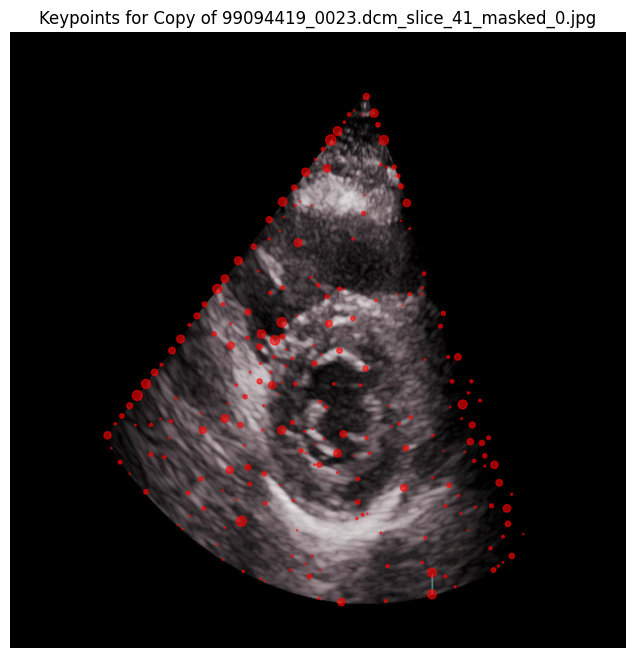

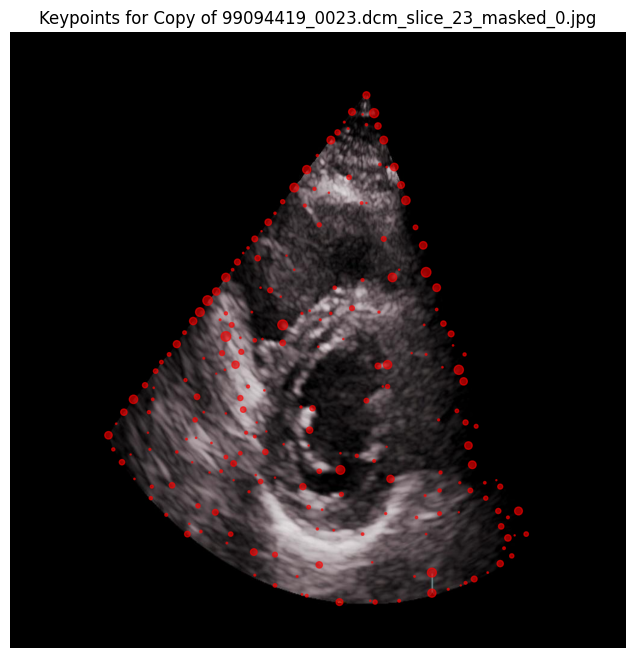

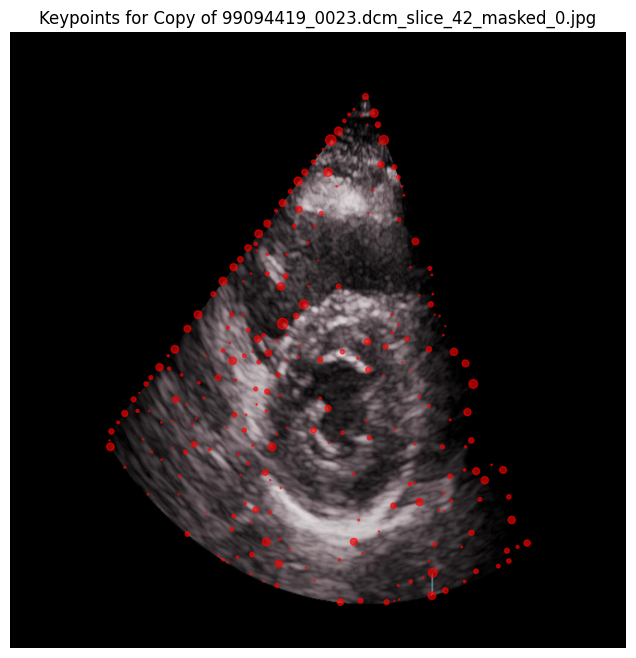

In [ ]:

# Path to your local image folder
local_image_folder = "/content/drive/MyDrive/grayson-2/p10159588/s99094419/test"
images = [os.path.join(local_image_folder, img) for img in os.listdir(local_image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

# Process and visualize keypoints for each image
for image_path in images[:3]:
    # Load image
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Preprocess the image
    inputs = processor(image, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract keypoints and scores
    keypoints = outputs.keypoints[0].cpu().numpy()  # Shape: (num_keypoints, 2)
    scores = outputs.scores[0].cpu().numpy()  # Shape: (num_keypoints,)


    # Get the shape of the input image sent to the model
    # The processor automatically resizes the image, so we need to scale accordingly
    input_width, input_height = inputs['pixel_values'].shape[-1], inputs['pixel_values'].shape[-2]

    # Scale keypoints back to the original image dimensions
    keypoints[:, 0] = keypoints[:, 0] * original_width / input_width  # Scale X-coordinates
    keypoints[:, 1] = keypoints[:, 1] * original_height / input_height  # Scale Y-coordinates

    # Filter keypoints within valid image bounds
    valid_keypoints = []
    valid_scores = []

    for kp, score in zip(keypoints, scores):
        if 0 <= kp[0] < original_width and 0 <= kp[1] < original_height:
            valid_keypoints.append(kp)
            valid_scores.append(score)

    # If we have valid keypoints, visualize them
    if valid_keypoints:
        valid_keypoints = np.array(valid_keypoints)
        valid_scores = np.array(valid_scores)

        # Visualize keypoints
        plt.figure(figsize=(8, 8))
        plt.imshow(np.asarray(image))
        plt.scatter(
            valid_keypoints[:, 0],  # X-coordinates
            valid_keypoints[:, 1],  # Y-coordinates
            s=valid_scores * 100,  # Scale point size by score
            c="red",  # Color of keypoints
            alpha=0.6  # Transparency
        )
        plt.axis("off")
        plt.title(f"Keypoints for {os.path.basename(image_path)}")
        plt.show()
    else:
        print("No valid keypoints to display.")

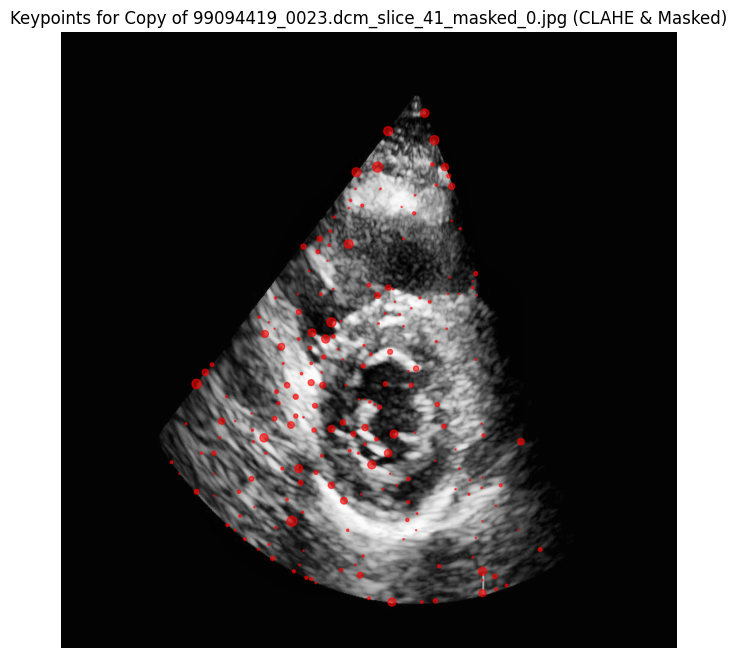

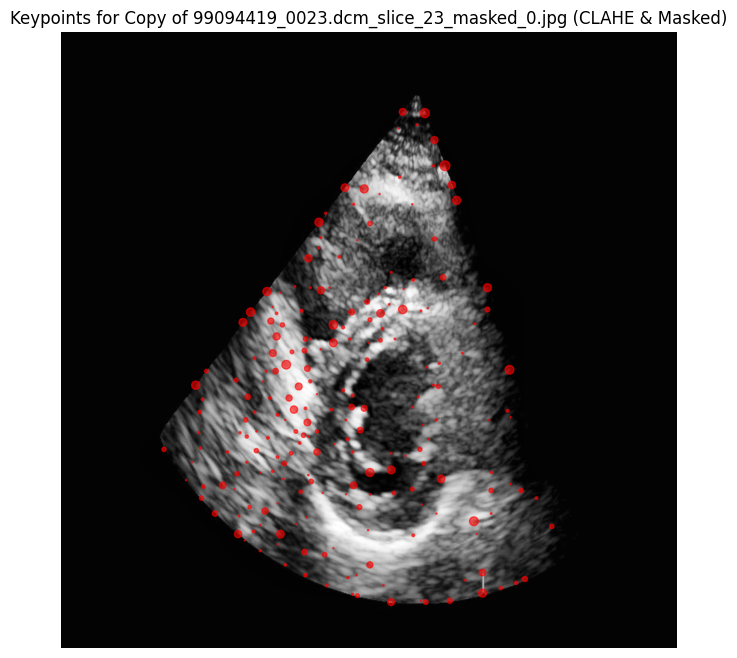

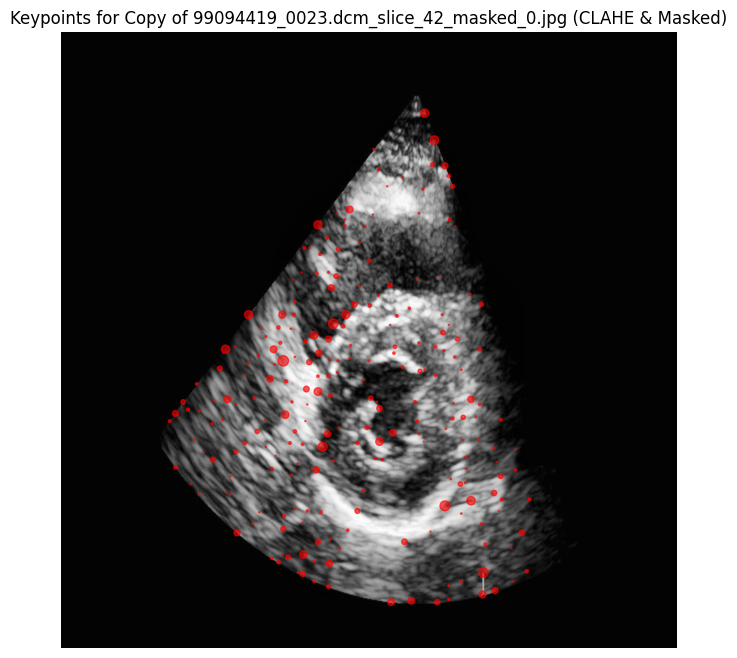

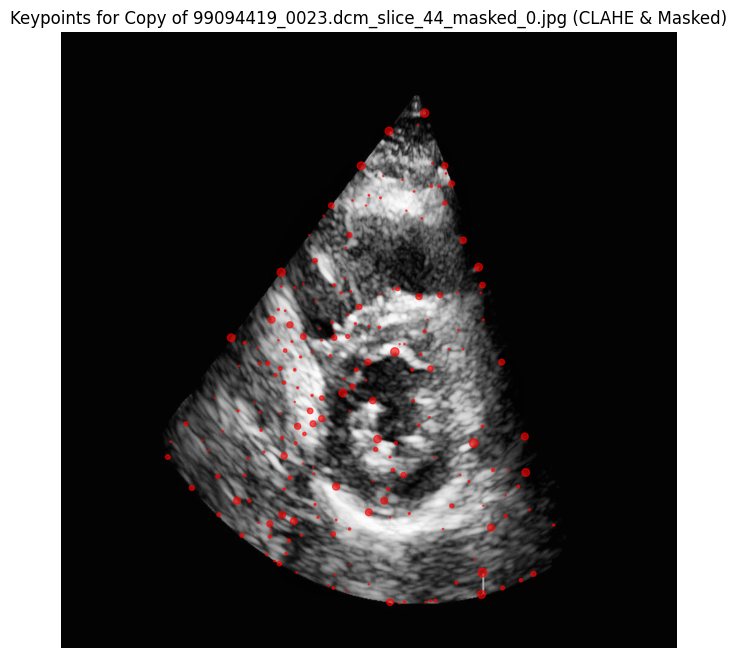

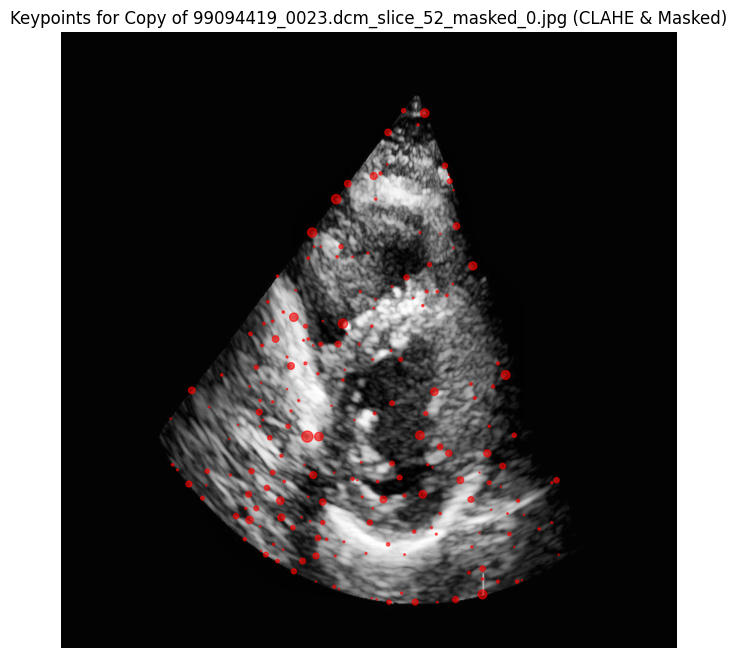

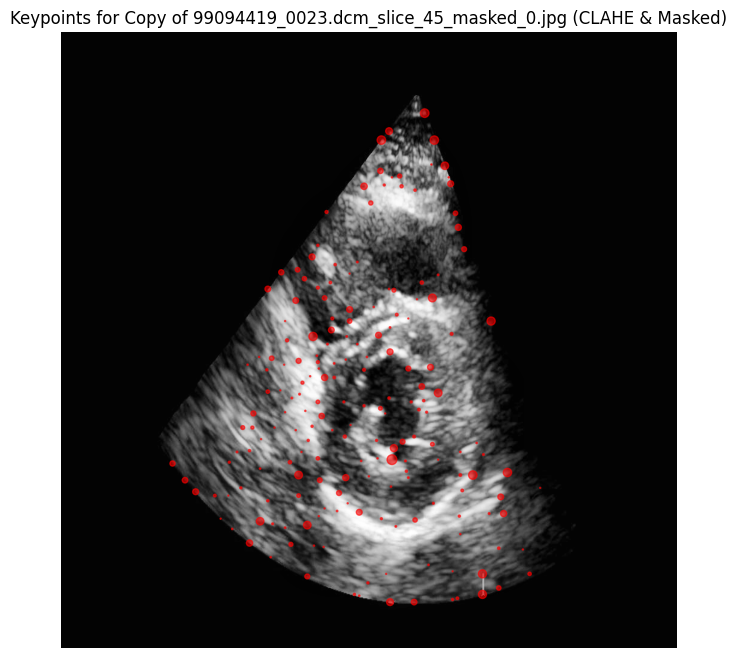

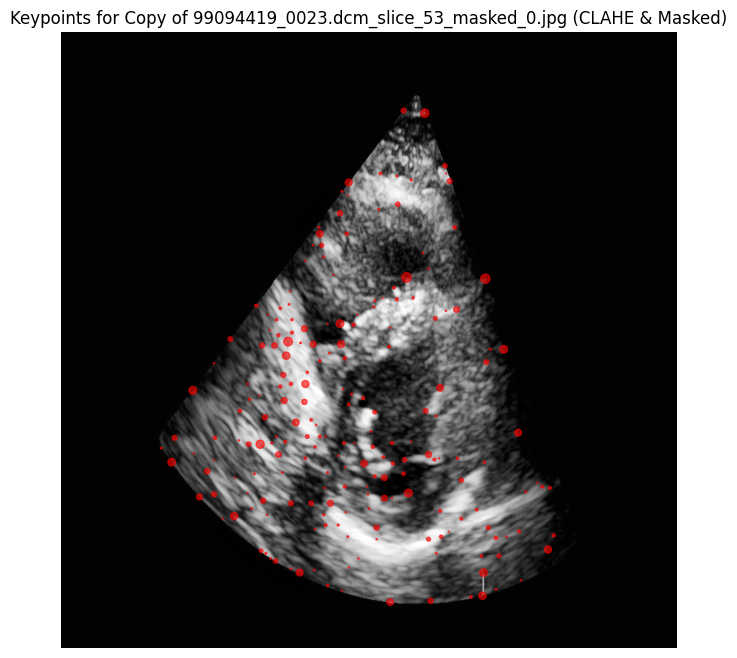

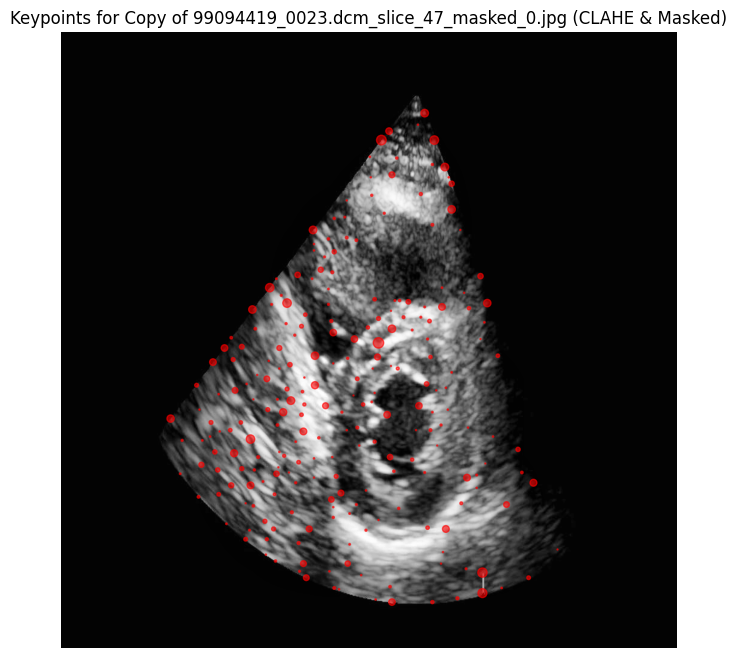

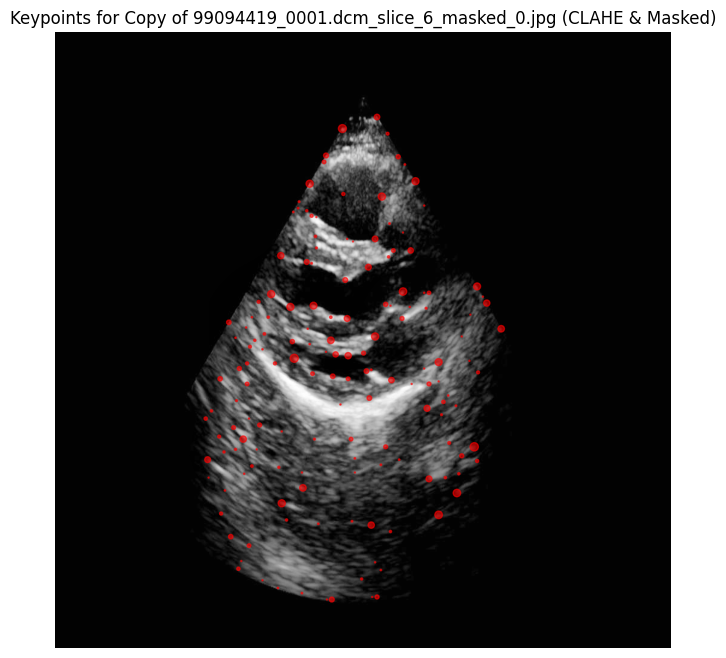

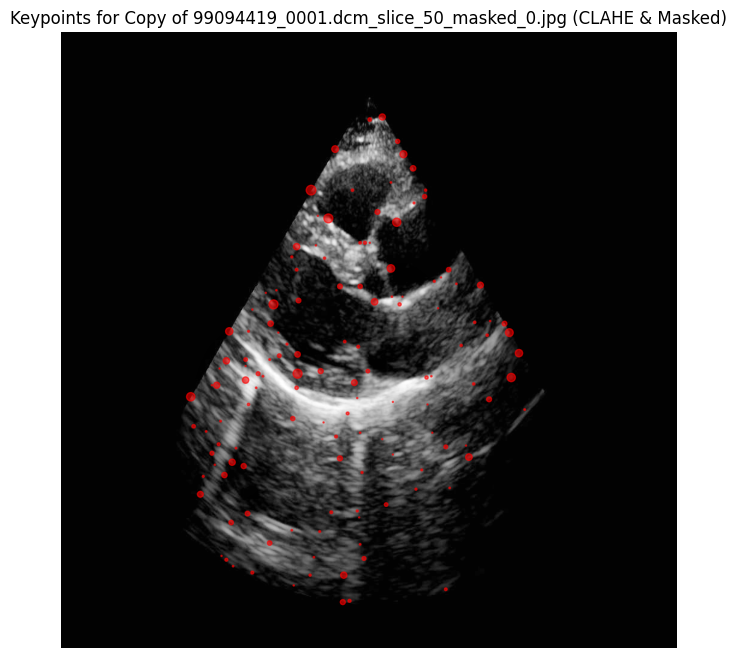

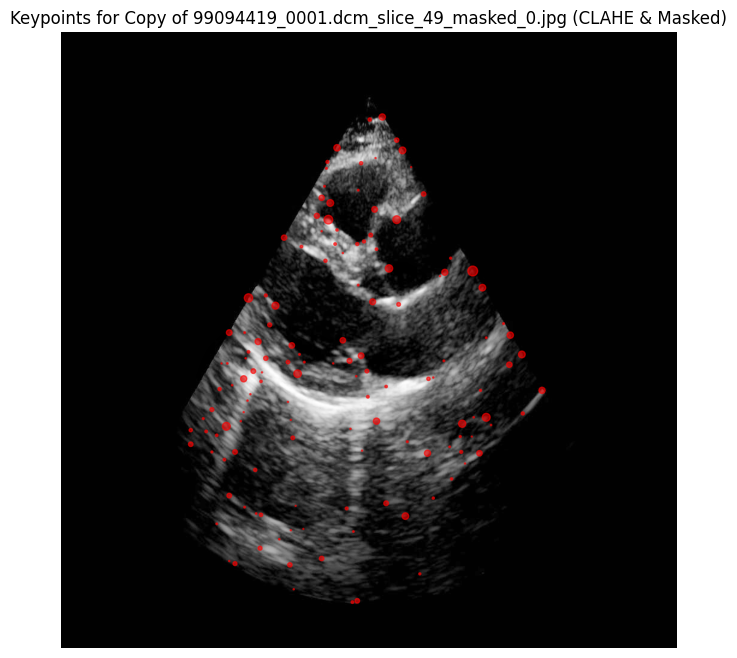

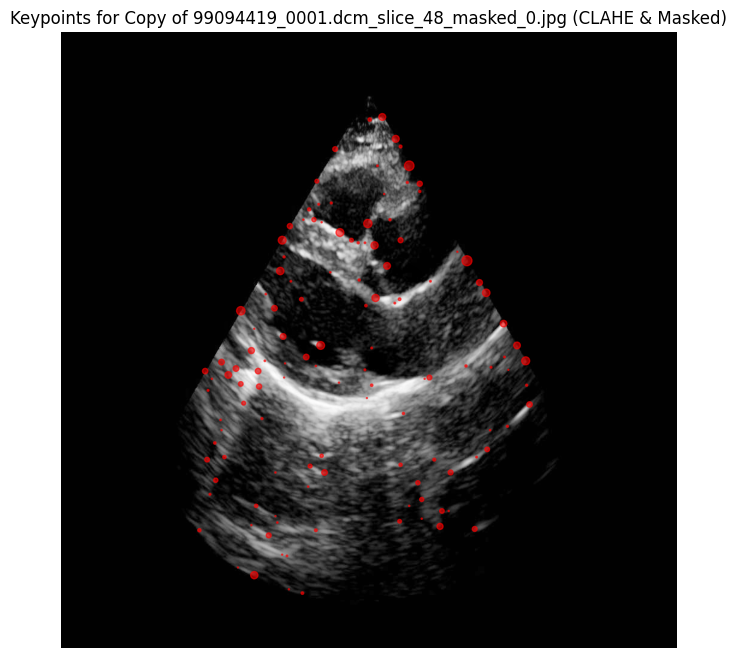

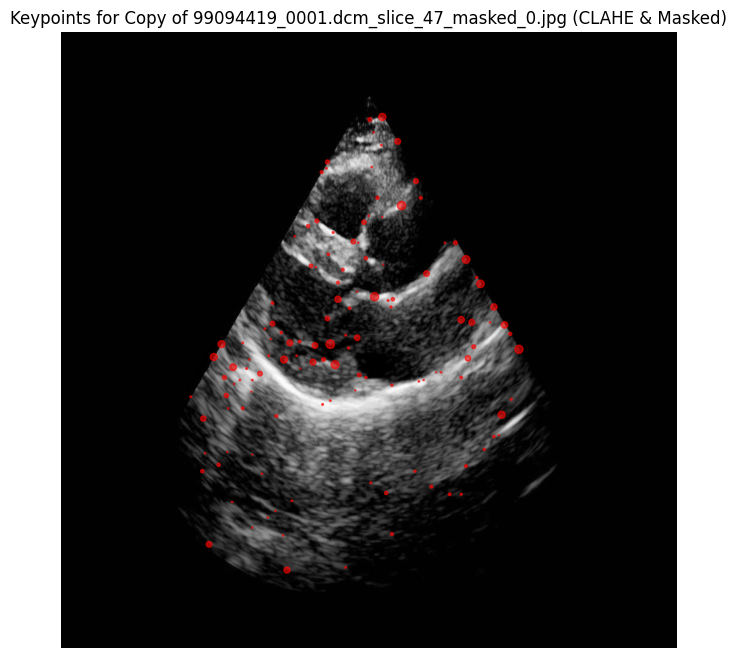

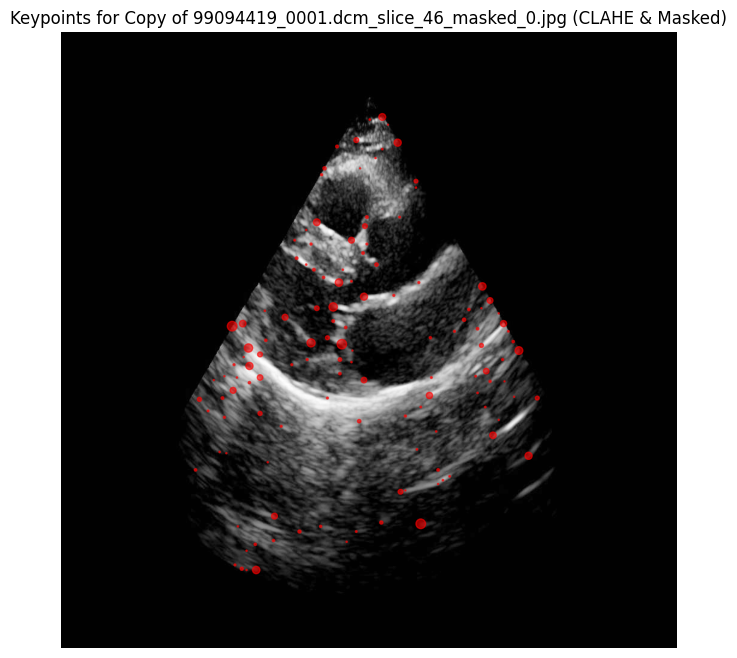

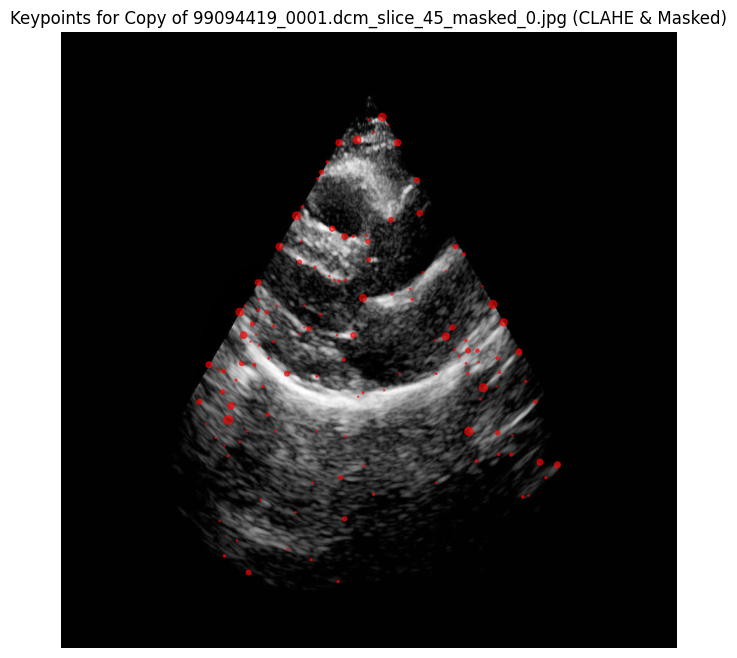

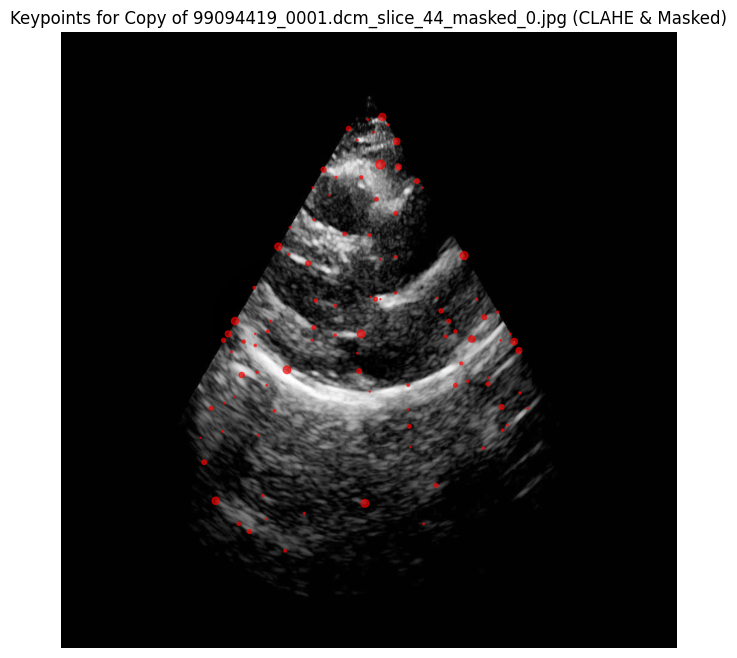

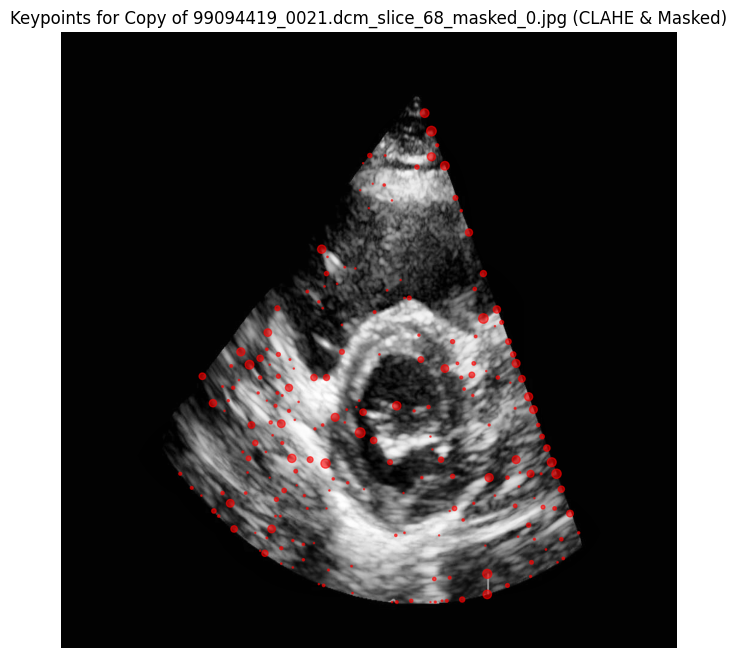

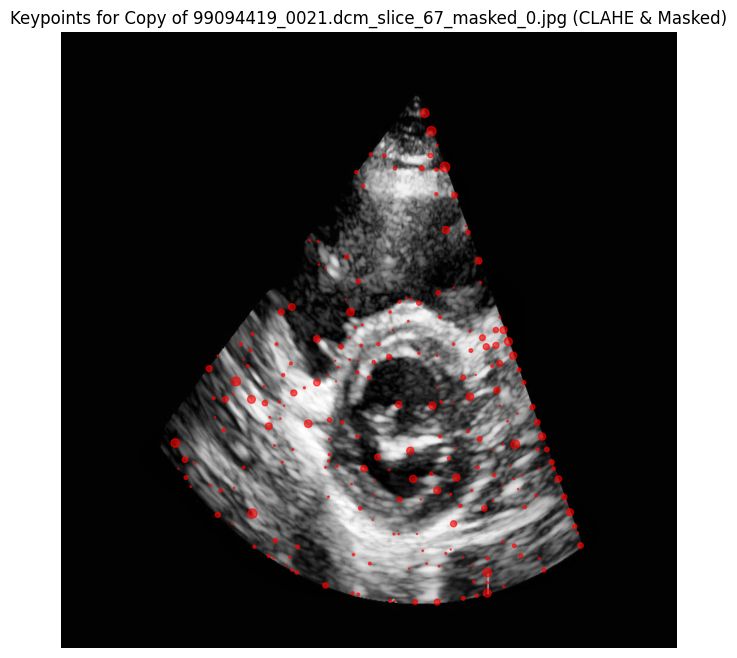

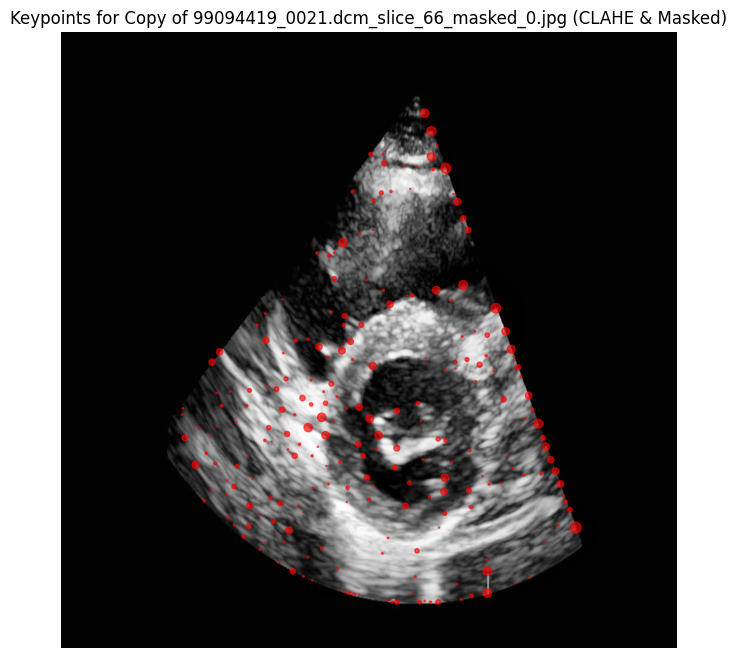

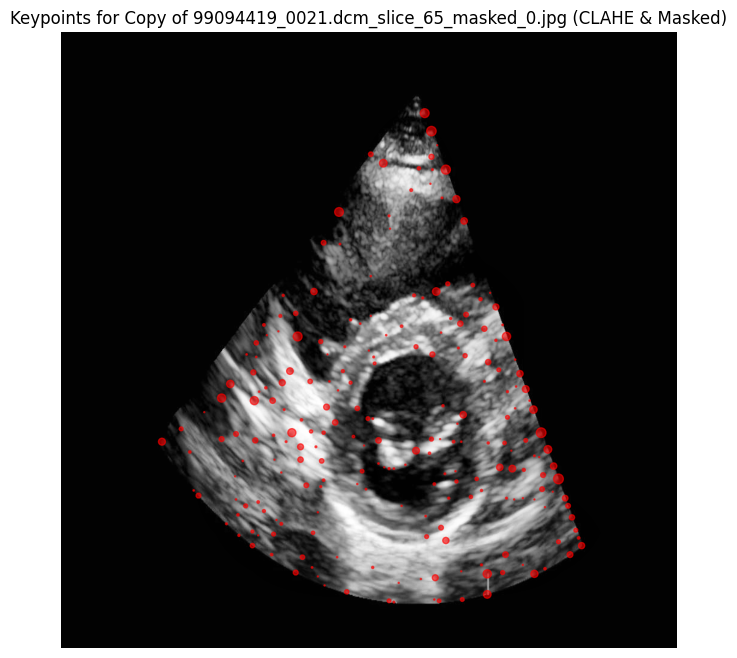

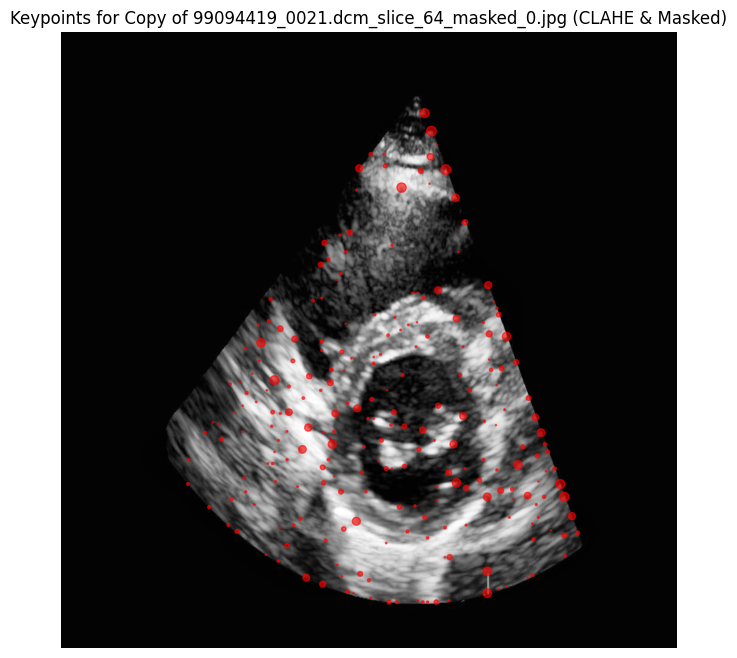

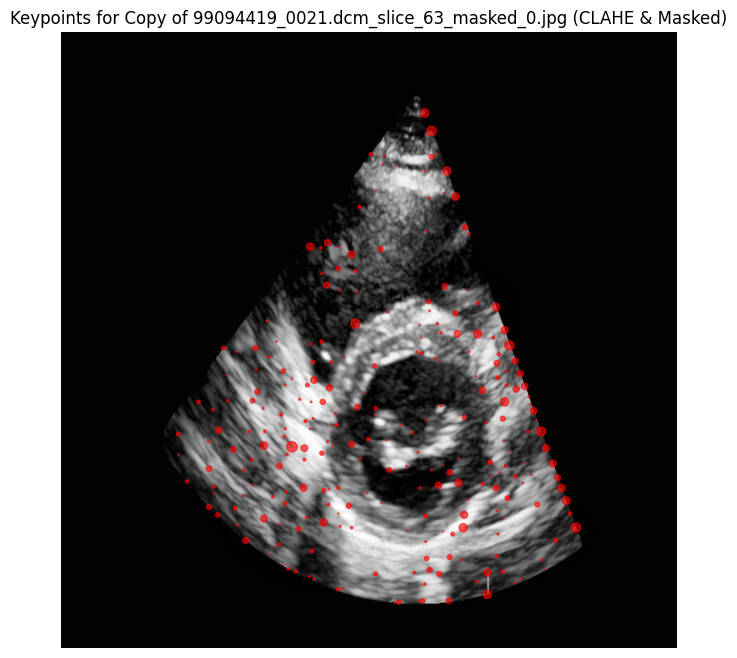

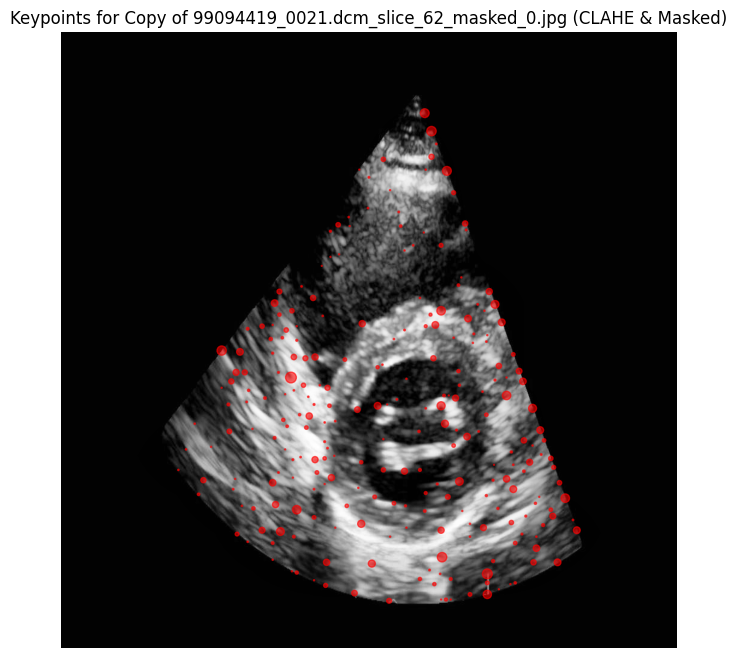

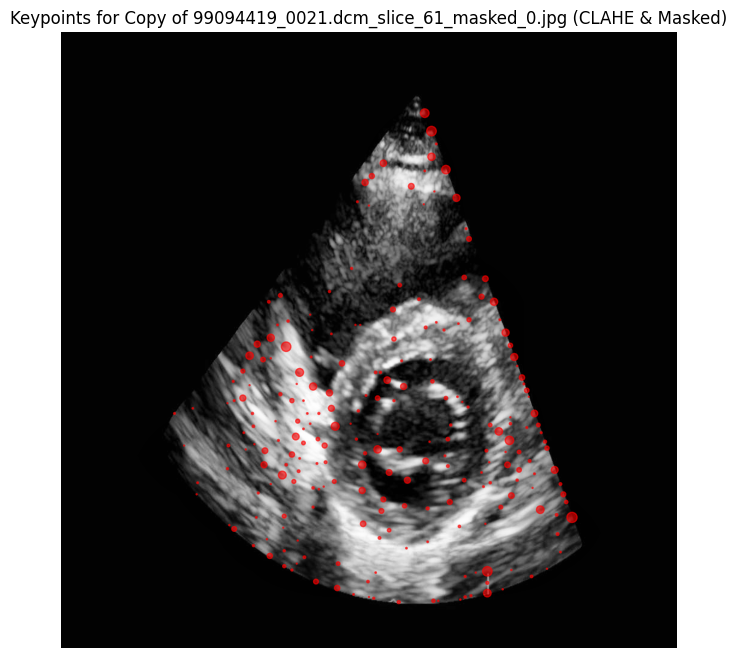

In [ ]:


# Load the image processor and model
processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# CLAHE Function to Enhance Features
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

# Intensity Normalization for Ultrasound Images
def normalize_intensity(image):
    image = np.array(image).astype(np.float32)
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Path to your local image folder
local_image_folder = "/content/drive/MyDrive/grayson-2/p10159588/s99094419/test"
images = [os.path.join(local_image_folder, img) for img in os.listdir(local_image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
images = images[:8] + images[100:108] + images[-8:]
# Process and visualize keypoints for each image
for image_path in images:
    # Load image
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Apply CLAHE and Intensity Normalization
    clahe_image = apply_clahe(image)
    normalized_image = normalize_intensity(clahe_image)

    # Convert grayscale image back to RGB
    preprocessed_image_rgb = cv2.cvtColor(normalized_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    preprocessed_image_pil = Image.fromarray(preprocessed_image_rgb)

    # Generate a binary mask for ultrasound area
    _, mask = cv2.threshold(normalized_image, 10, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=2)

    # Preprocess for SuperPoint
    inputs = processor(preprocessed_image_pil, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract keypoints and scores
    keypoints = outputs.keypoints[0].cpu().numpy()
    scores = outputs.scores[0].cpu().numpy()

    # Scale keypoints back to the original image dimensions
    input_width, input_height = inputs['pixel_values'].shape[-1], inputs['pixel_values'].shape[-2]
    keypoints[:, 0] = keypoints[:, 0] * original_width / input_width
    keypoints[:, 1] = keypoints[:, 1] * original_height / input_height

    # Filter keypoints using the binary mask
    valid_keypoints, valid_scores = [], []
    for kp, score in zip(keypoints, scores):
        x, y = int(kp[0]), int(kp[1])
        if mask[y, x] > 0:  # Keep keypoints within ROI
            valid_keypoints.append(kp)
            valid_scores.append(score)

    # Visualize keypoints
    if valid_keypoints:
        valid_keypoints = np.array(valid_keypoints)
        valid_scores = np.array(valid_scores)

        plt.figure(figsize=(8, 8))
        plt.imshow(normalized_image, cmap="gray")
        plt.scatter(
            valid_keypoints[:, 0],
            valid_keypoints[:, 1],
            s=valid_scores * 100,
            c="red",
            alpha=0.6
        )
        plt.title(f"Keypoints for {os.path.basename(image_path)} (CLAHE & Masked)")
        plt.axis("off")
        plt.show()
    else:
        print(f"No valid keypoints to display for {os.path.basename(image_path)}.")


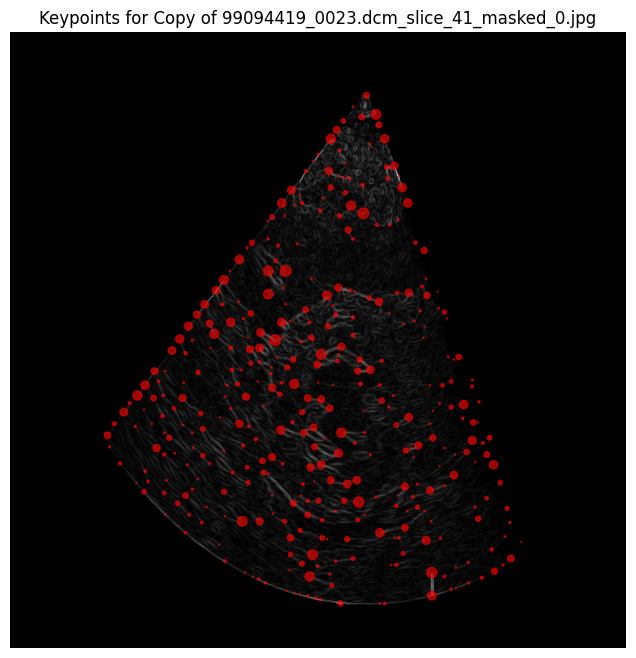

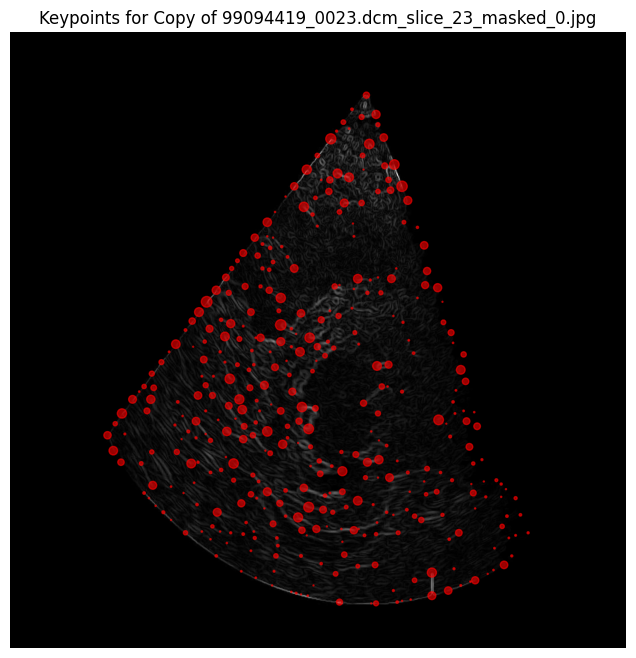

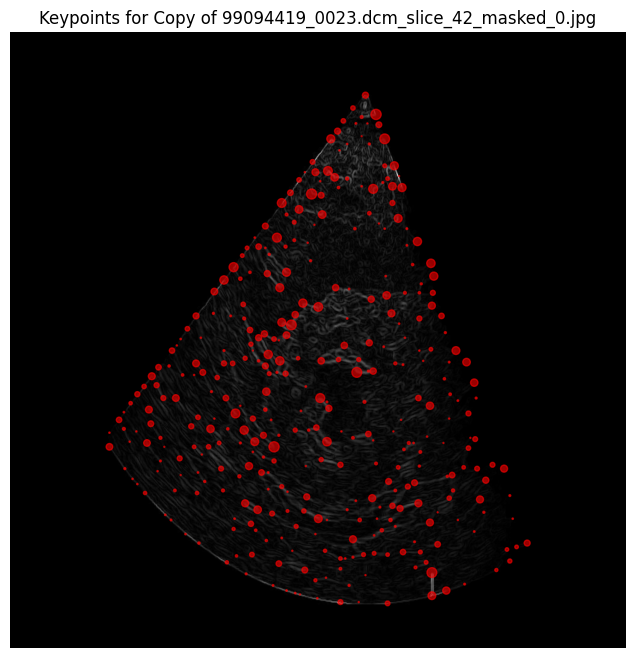

In [14]:
# Sobel edge detection
def apply_sobel(image):
    """
    Apply Sobel edge detection to highlight edges in the image.
    """
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(255 * sobel_combined / np.max(sobel_combined))
    return sobel_combined

def apply_clahe(image, clip_limit=4.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE to enhance image contrast.
    """
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

# Intensity normalization for ultrasound images
def normalize_intensity(image):
    """
    Normalize pixel intensity to range [0, 255].
    """
    image = np.array(image).astype(np.float32)
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Preprocess image
def preprocess_image(image_path):
    """
    Load and preprocess the image using Sobel edge detection and intensity normalization.
    """
    image = Image.open(image_path).convert("RGB")
    clahe_image = apply_clahe(image)
    sobel_image = apply_sobel(clahe_image)
    normalized_image = normalize_intensity(sobel_image)

    # Convert grayscale image back to RGB
    preprocessed_image_rgb = cv2.cvtColor(normalized_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    return Image.fromarray(preprocessed_image_rgb)

# Path to your local image folder
local_image_folder = "/content/drive/MyDrive/grayson-2/p10159588/s99094419/test"
images = [os.path.join(local_image_folder, img) for img in os.listdir(local_image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

for image_path in images[:3]:
    # Load and preprocess image
    original_image = Image.open(image_path).convert("RGB")
    original_width, original_height = original_image.size
    sobel_image = apply_sobel(original_image)  # Apply Sobel edge detection


    # Normalize Sobel image and convert to RGB for SuperPoint
    normalized_image = normalize_intensity(sobel_image)
    preprocessed_image_rgb = cv2.cvtColor(normalized_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    preprocessed_image = Image.fromarray(preprocessed_image_rgb)

    # Preprocess for SuperPoint
    inputs = processor(preprocessed_image, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract keypoints and scores
    keypoints = outputs.keypoints[0].cpu().numpy()  # Shape: (num_keypoints, 2)
    scores = outputs.scores[0].cpu().numpy()  # Shape: (num_keypoints,)

    # Get the shape of the input image sent to the model
    input_width, input_height = inputs['pixel_values'].shape[-1], inputs['pixel_values'].shape[-2]

    # Correct scaling logic
    keypoints[:, 0] *= input_width  # Scale X-coordinates
    keypoints[:, 1] *= input_height  # Scale Y-coordinates
    keypoints[:, 0] = keypoints[:, 0] * original_width / input_width
    keypoints[:, 1] = keypoints[:, 1] * original_height / input_height

    # Visualize keypoints
    if len(keypoints) > 0:
        plt.figure(figsize=(8, 8))
        plt.imshow(np.asarray(sobel_image), cmap="gray")
        plt.scatter(
            keypoints[:, 0],  # X-coordinates
            keypoints[:, 1],  # Y-coordinates
            s=scores * 100,  # Scale point size by score
            c="red",  # Color of keypoints
            alpha=0.6  # Transparency
        )
        plt.axis("off")
        plt.title(f"Keypoints for {os.path.basename(image_path)}")
        plt.show()
    else:
        print(f"No keypoints detected for {os.path.basename(image_path)}.")


Computing similarities: 100%|██████████| 24/24 [00:00<00:00, 81.66it/s]


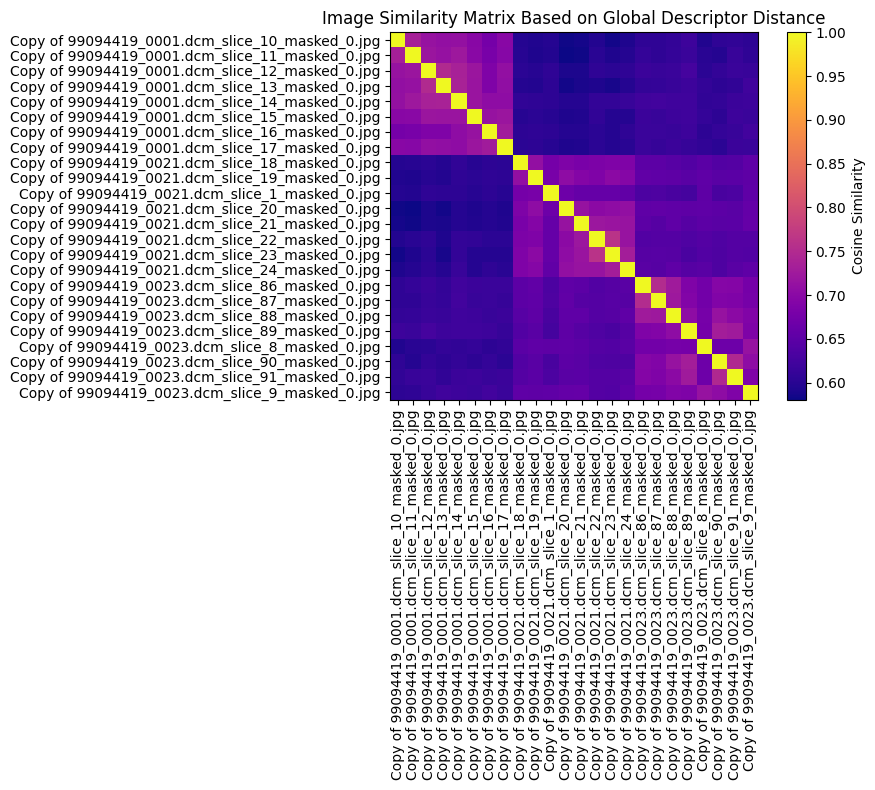

In [ ]:


# Load SuperPoint model and processor
processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# CLAHE and Intensity Normalization for Preprocessing
def apply_clahe(image, clip_limit=4.0, tile_grid_size=(8, 8)):  # Higher contrast
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

def normalize_intensity(image):
    image = np.array(image).astype(np.float32)
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Preprocess image: CLAHE -> Normalization -> Resize
def preprocess_image(image_path, target_size=(1024, 1024)):
    image = Image.open(image_path).convert("RGB")
    clahe_image = apply_clahe(image)
    normalized_image = normalize_intensity(clahe_image)

    # Convert to RGB (3 channels)
    rgb_image = cv2.cvtColor(normalized_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    resized_image = Image.fromarray(rgb_image).resize(target_size)
    return resized_image

# Extract SuperPoint features
def extract_features(image, processor, model):
    inputs = processor(image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    keypoints = outputs.keypoints[0].cpu().numpy()
    descriptors = outputs.descriptors[0].cpu().numpy()

    # Ensure descriptors are (256, N)
    if descriptors.shape[0] != 256:
        descriptors = descriptors.T

    return keypoints, descriptors

# Compute global descriptor similarity
def compute_descriptor_similarity(desc1, desc2, method="cosine"):
    """
    Compute global similarity between two sets of descriptors.
    Supports L2 distance or cosine similarity.
    """
    if desc1.shape[1] == 0 or desc2.shape[1] == 0:
        return float('inf') if method == "l2" else 0.0  # No descriptors

    # Reshape descriptors to 2D
    desc1 = desc1.T  # Shape: (num_descriptors1, 256)
    desc2 = desc2.T  # Shape: (num_descriptors2, 256)

    if method == "l2":
        # Compute L2 distances between all descriptors
        distances = np.linalg.norm(desc1[:, None] - desc2[None, :], axis=2)
        return np.mean(np.min(distances, axis=1))  # Average over closest matches
    elif method == "cosine":
        # Normalize descriptors for cosine similarity
        desc1_norm = desc1 / np.linalg.norm(desc1, axis=1, keepdims=True)
        desc2_norm = desc2 / np.linalg.norm(desc2, axis=1, keepdims=True)
        cosine_similarity = np.dot(desc1_norm, desc2_norm.T)
        return np.mean(np.max(cosine_similarity, axis=1))  # Average over closest matches
    else:
        raise ValueError("Method must be 'l2' or 'cosine'")

# Compute batch similarity between all images
def compute_batch_similarity(image_folder, processor, model, method="cosine"):
    # Load images
    image_paths = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))])
    image_subset = image_paths[:8] + image_paths[100:108] + image_paths[-8:]

    # Extract features for all images
    features = {}
    for image_path in tqdm(image_subset, desc="Processing images"):
        resized_image = preprocess_image(image_path)
        _, descriptors = extract_features(resized_image, processor, model)
        features[image_path] = descriptors  # Save descriptors for efficiency

    # Initialize similarity matrix
    num_images = len(image_subset)
    similarity_matrix = np.zeros((num_images, num_images))

    # Compare each pair of images
    for i in tqdm(range(num_images), desc="Computing similarities"):
        desc1 = features[image_subset[i]]
        for j in range(i, num_images):
            desc2 = features[image_subset[j]]

            # Compute global descriptor similarity
            if method == "l2":
                score = compute_descriptor_similarity(desc1, desc2, method="l2")
            else:
                score = compute_descriptor_similarity(desc1, desc2, method="cosine")

            # Populate similarity matrix
            similarity_matrix[i, j] = score
            similarity_matrix[j, i] = score  # Symmetric matrix

    return similarity_matrix, image_subset

# Plot the similarity matrix
def plot_similarity_matrix(similarity_matrix, image_paths, method="cosine"):
    plt.figure(figsize=(10, 8))
    cmap = 'Blues' if method == "l2" else 'plasma'
    plt.imshow(similarity_matrix, cmap=cmap, interpolation='nearest')
    plt.colorbar(label="Cosine Similarity" if method == "cosine" else "L2 Distance")
    plt.xticks(ticks=np.arange(len(image_paths)), labels=[os.path.basename(p) for p in image_paths], rotation=90)
    plt.yticks(ticks=np.arange(len(image_paths)), labels=[os.path.basename(p) for p in image_paths])
    plt.title("Image Similarity Matrix Based on Global Descriptor Distance")
    plt.tight_layout()
    plt.show()


image_folder = "/content/drive/MyDrive/grayson-2/p10159588/s99094419/test"

# Compute batch similarity
similarity_matrix, image_paths = compute_batch_similarity(image_folder, processor, model, method="cosine")

# Plot the similarity matrix
plot_similarity_matrix(similarity_matrix, image_paths, method="cosine")

# Save the similarity matrix
#np.savetxt("global_similarity_matrix.csv", similarity_matrix, delimiter=",", fmt="%.4f")


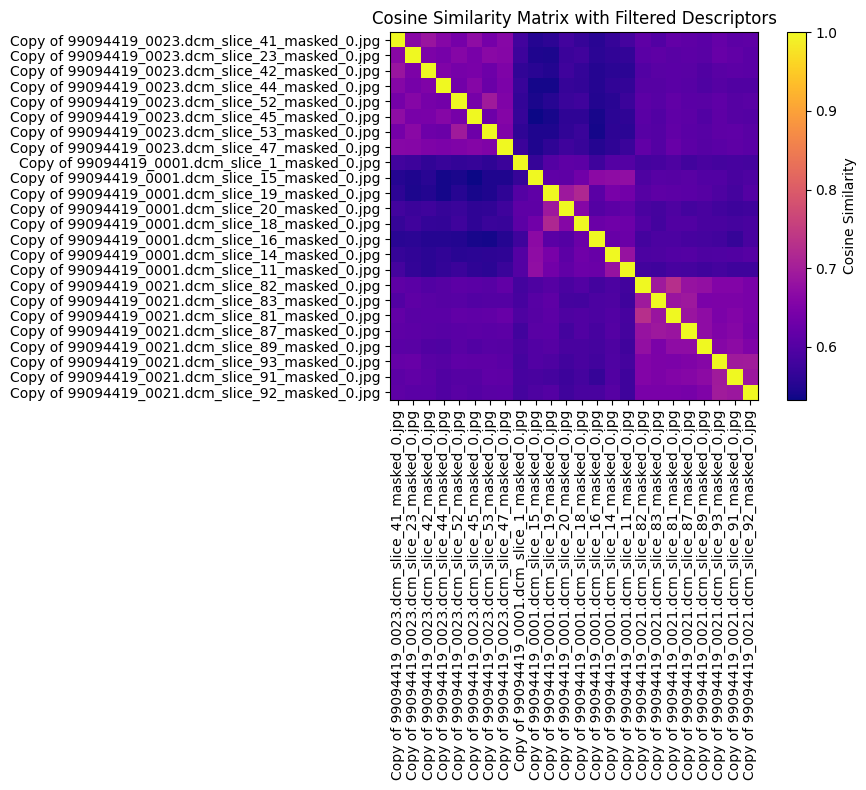

In [ ]:


# Load the image processor and model
processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# CLAHE Function to Enhance Features
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

# Intensity Normalization for Ultrasound Images
def normalize_intensity(image):
    image = np.array(image).astype(np.float32)
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Filter keypoints and descriptors using binary mask
def filter_keypoints_and_descriptors(keypoints, descriptors, mask):
    valid_keypoints = []
    valid_descriptors = []

    for i, kp in enumerate(keypoints):
        x, y = int(kp[0]), int(kp[1])
        if mask[y, x] > 0:  # Check if keypoint is within the mask
            valid_keypoints.append(kp)
            valid_descriptors.append(descriptors[:, i])  # Keep corresponding descriptor

    return np.array(valid_keypoints), np.array(valid_descriptors).T if valid_descriptors else (None, None)

# Compute cosine similarity between descriptor sets
def compute_cosine_similarity(desc1, desc2):
    if desc1 is None or desc2 is None or desc1.shape[1] == 0 or desc2.shape[1] == 0:
        return 0.0  # Return zero similarity if descriptors are empty

    # Normalize descriptors
    desc1_norm = desc1 / np.linalg.norm(desc1, axis=0, keepdims=True)
    desc2_norm = desc2 / np.linalg.norm(desc2, axis=0, keepdims=True)

    # Compute cosine similarity matrix
    cosine_similarity = np.dot(desc1_norm.T, desc2_norm)  # Shape: (N1, N2)
    max_similarity = np.mean(np.max(cosine_similarity, axis=1))  # Average of best matches
    return max_similarity

# Path to your local image folder
local_image_folder = "/content/drive/MyDrive/grayson-2/p10159588/s99094419/test"
images = [os.path.join(local_image_folder, img) for img in os.listdir(local_image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
images = images[:8] + images[100:108] + images[-8:]

# Extract filtered descriptors for each image
filtered_descriptors = {}
for image_path in images:
    # Load image
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Preprocess: CLAHE and Intensity Normalization
    clahe_image = apply_clahe(image)
    normalized_image = normalize_intensity(clahe_image)

    # Binary mask for ultrasound region
    _, mask = cv2.threshold(normalized_image, 10, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=2)

    # Preprocess for SuperPoint
    inputs = processor(Image.fromarray(normalized_image).convert("RGB"), return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract keypoints and descriptors
    keypoints = outputs.keypoints[0].cpu().numpy()
    descriptors = outputs.descriptors[0].cpu().numpy()
    if descriptors.shape[0] != 256:
        descriptors = descriptors.T

    # Scale keypoints
    input_width, input_height = inputs['pixel_values'].shape[-1], inputs['pixel_values'].shape[-2]
    keypoints[:, 0] = keypoints[:, 0] * original_width / input_width
    keypoints[:, 1] = keypoints[:, 1] * original_height / input_height

    # Filter keypoints and descriptors using mask
    valid_keypoints, valid_descriptors = filter_keypoints_and_descriptors(keypoints, descriptors, mask)
    filtered_descriptors[image_path] = valid_descriptors

# Compute cosine similarity between all image pairs
num_images = len(images)
similarity_matrix = np.zeros((num_images, num_images))

for i in range(num_images):
    for j in range(i, num_images):
        desc1 = filtered_descriptors[images[i]]
        desc2 = filtered_descriptors[images[j]]

        # Compute cosine similarity
        similarity = compute_cosine_similarity(desc1, desc2)
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Symmetric

# Visualize similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap="plasma", interpolation="nearest")
plt.colorbar(label="Cosine Similarity")
plt.xticks(ticks=np.arange(num_images), labels=[os.path.basename(p) for p in images], rotation=90)
plt.yticks(ticks=np.arange(num_images), labels=[os.path.basename(p) for p in images])
plt.title("Cosine Similarity Matrix with Filtered Descriptors")
plt.tight_layout()
plt.show()
